# Basic Preprocessing and Connected Components

In [8]:
from tifffile import imread, imsave
import numpy as np
import matplotlib.pyplot as plt
import cv2

exp_name = 'cell_detection_8'

def show_image(img_3d, slice_z):
    if slice_z:
        img_slice = img_3d[slice_z, :, :]
    else:
        img_slice = img_3d
            
    plt.imshow(img_slice, cmap=plt.cm.gray)
    plt.figure(figsize=(800,800))
    plt.show()

## Image Histogram

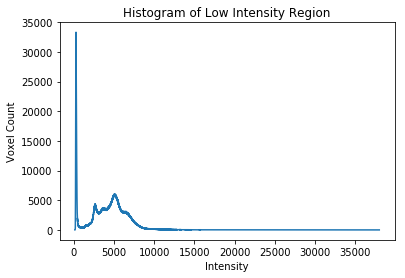

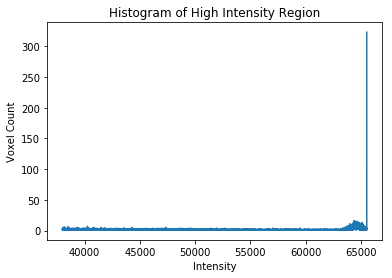

In [16]:
img = imread('{}.tiff'.format(exp_name))

uniq = np.unique(img, return_counts=True)

uniq_set_high_intensity = [(v, uniq[1][i]) for i,v in enumerate(uniq[0]) if v >= 38000]
hist_x_hi = [p[0] for p in uniq_set_high_intensity]
hist_y_hi = [p[1] for p in uniq_set_high_intensity]

uniq_set_low_intensity = [(v, uniq[1][i]) for i,v in enumerate(uniq[0]) if v < 38000]
hist_x_li = [p[0] for p in uniq_set_low_intensity]
hist_y_li = [p[1] for p in uniq_set_low_intensity]

plt.plot(hist_x_li, hist_y_li)
plt.xlabel('Intensity')
plt.ylabel('Voxel Count')
plt.title('Histogram of Low Intensity Region')

plt.savefig('hist_low.png')
plt.show()


plt.plot(hist_x_hi, hist_y_hi)
plt.xlabel('Intensity')
plt.ylabel('Voxel Count')
plt.title('Histogram of High Intensity Region')

plt.savefig('hist_high.png')
plt.show()



shape_z, shape_y, shape_x = img.shape

## GMM Clustering

38779


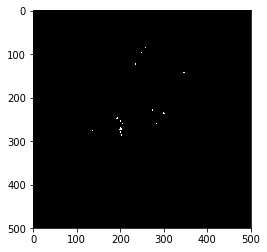

In [10]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import scipy.stats
import time

SOME_BIG_VALUE = img.max() + 1000

def gmm_img(data_points):
    n_components = 3
    gmm = GaussianMixture(n_components=n_components, covariance_type='full').fit(data_points)
    cluster_labels = gmm.predict(data_points)
    cluster_centers = np.empty((n_components, len(data_points[0])))

    for i in range(n_components):
        density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i], allow_singular=True).logpdf(data_points)
        cluster_centers[i, :] = data_points[np.argmax(density)]
    
    max_intensity = max([p[0] for p in cluster_centers])
    max_intensity_cluster = [i for i, v in enumerate(cluster_centers) if v[0] == max_intensity][0]
    avg_intensity = int(gmm.means_[max_intensity_cluster][0])

    new_img = np.ndarray((shape_z, shape_y, shape_x))
    np.copyto(new_img, img)
    print(avg_intensity)
    new_img[img >= avg_intensity] = 255
    new_img[img < avg_intensity] = 0
        
    return new_img

start = time.clock()

data_points = [p for p in zip(*uniq)]

gm_img = gmm_img(data_points)
show_image(gm_img, 50)

## Otsu's Binarization

In [4]:
# from skimage.filters import threshold_otsu

# thresh = threshold_otsu(img)
# binary_img = (img > thresh) * 255
# binary_img = binary_img.astype(np.uint8)

# show_image(binary_img, 25)

# start = time.clock()

## Adaptive Thresholding

In [5]:
# img_threshold = np.zeros((shape_z, shape_y, shape_x))

# for z_slice in range(shape_z):
#     img_threshold[z_slice, :, :] = cv2.adaptiveThreshold(binary_img[z_slice, :, :], 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# img_threshold = abs(img_threshold - 255)

# show_image(img_threshold, 30)

## Morphological Hole Filling (Dilation)

In [6]:
# from scipy.ndimage.morphology import binary_fill_holes
# from skimage.morphology import binary_dilation, binary_erosion, erosion, cube

# eroded_img = np.zeros((shape_z, shape_y, shape_x))
# eroded_img = binary_erosion(gm_img, cube(2))
# # for z_slice in range(shape_z):
# #     eroded_img[z_slice, :, :] = binary_erosion(gm_img[z_slice, :, :], disk(1))
    
# imsave('eroded_test.tiff', eroded_img.astype(np.uint16))

# # dilated_img = np.zeros((shape_z, shape_y, shape_x))

# # for z_slice in range(shape_z):
# #     dilated_img[z_slice, :, :] = binary_fill_holes(binary_dilation(img_threshold[z_slice, :, :]))

# # dilated_img *= 255

# # show_image(dilated_img, 30)

## Connected Components

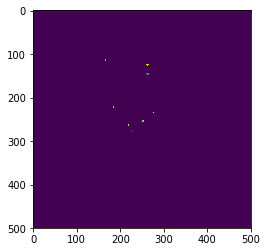

143
calculating centroid 10
calculating centroid 20
calculating centroid 30
calculating centroid 40
calculating centroid 50
calculating centroid 60
calculating centroid 70
calculating centroid 80
calculating centroid 90
calculating centroid 100
calculating centroid 110
calculating centroid 120
calculating centroid 130
calculating centroid 140
Predictions saved to CSV
15.169436000000001


In [7]:
from skimage import measure
import math
import csv

def find_centroid(voxels):
    sum_z = 0.0
    sum_y = 0.0
    sum_x = 0.0
    
    l = float(len(voxels))

    if l == 0:
        return None
    
    for voxel in voxels:
        z, y, x = voxel
        sum_z += z
        sum_y += y
        sum_x += x
    
    return (math.ceil(sum_z/l), math.ceil(sum_y/l), math.ceil(sum_x/l))

#cc_img = measure.label(dilated_img, background=0)
cc_img = measure.label(gm_img, background=0)
#cc_img = measure.label(basic_th_img, background=0)

plt.imshow(cc_img[30, :, :])
plt.show()

img_segments = np.unique(cc_img, return_counts=True)

centroids = []

print(len(img_segments[0]))

for segment_index in range(1, len(img_segments[0])):
    if segment_index % 10 == 0: print('calculating centroid {}'.format(segment_index))
    voxels = [i for i in zip(*np.where(cc_img == segment_index))]
    centroids.append(find_centroid(voxels))
    
with open('{}_predicted.csv'.format(exp_name), 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(centroids)

print('Predictions saved to CSV')
end = time.clock()
print(end - start)